# Vasicek Model for Fixed Income
Xutao Chen
Jan. 27th

Vasicek Model is a classical term structure model that is still very popular in industry. This code sample shows three main achievements:

1.Retrieve Eurodollar Futures data from data supplier, and pre-process it

2.Build a 1-Factor Vasicek Model, and estimate the parameters with historical data

3.Test the model

In [2]:
# Import all necessary package
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.arima_model import ARMA
import quandl
import QuantLib as ql
from scipy.optimize import least_squares,leastsq
from scipy.stats import probplot,spearmanr
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1 Data Processing

In [3]:
# Retrive the settle prices of first 20 (most liquid) rolling Eurodollar futures from Quandl
token = "faF8P6bZjqdiDsRaXipz"
n = range(5,21)
nms = ["CHRIS/CME_ED"+str(i) for i in n]
dfs = [quandl.get(nm, authtoken=token) for nm in nms]

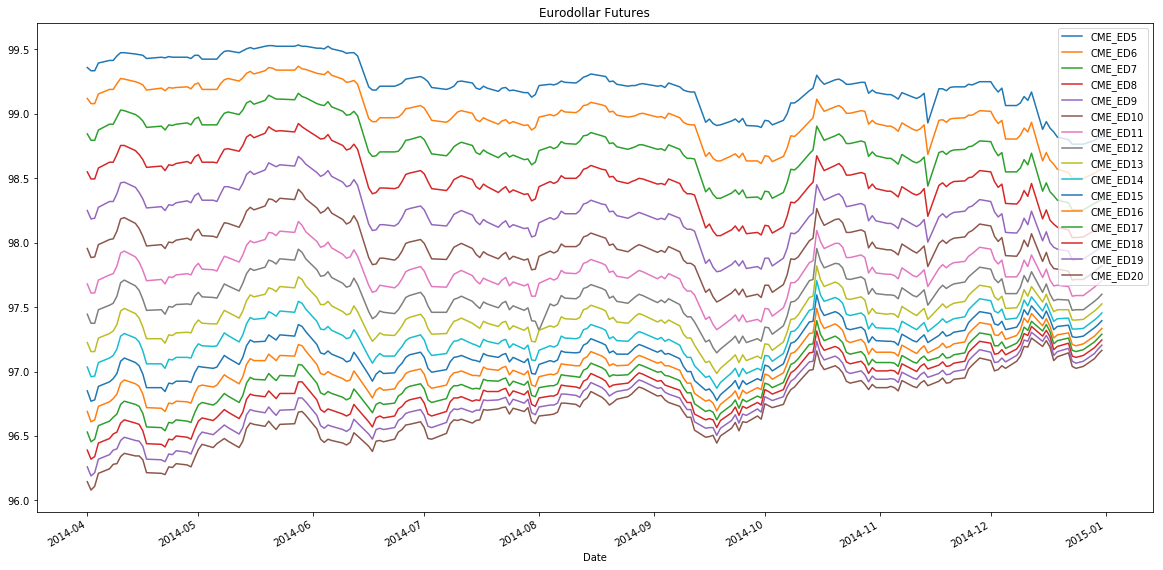

In [6]:
# Put all settle price into 1 dataframe
settle = []
for i in range(16):
    settle.append(dfs[i]["Settle"])
    
df = pd.concat(settle,axis=1)
term = ["CME_ED"+str(i) for i in n]
df.columns = term
df = df.dropna()
sample = df.loc["2014-04-01":"2014-12-31"]
sample.plot(figsize=(20,10))
plt.title('Eurodollar Futures')
plt.show()

#### Observation
Apparently, there is periodic jump for the Eurodollar rates. However, these jump is not due to market effect, but to CME's price listing operation. They will cause problem for further data analysis, so we need to process it and convert it to constant-maturity rates.

Notice: The Eurodollar futures' maturity date is the third Wednesday of that month. In the data retrieved from CME, the duration between future's maturity is about one quarter.
    Before June 2016, CME stop front futures's trading on the last Sunday before maturity date,
    so the first future price listed on Monday before maturity date is for second-to-matured futures;

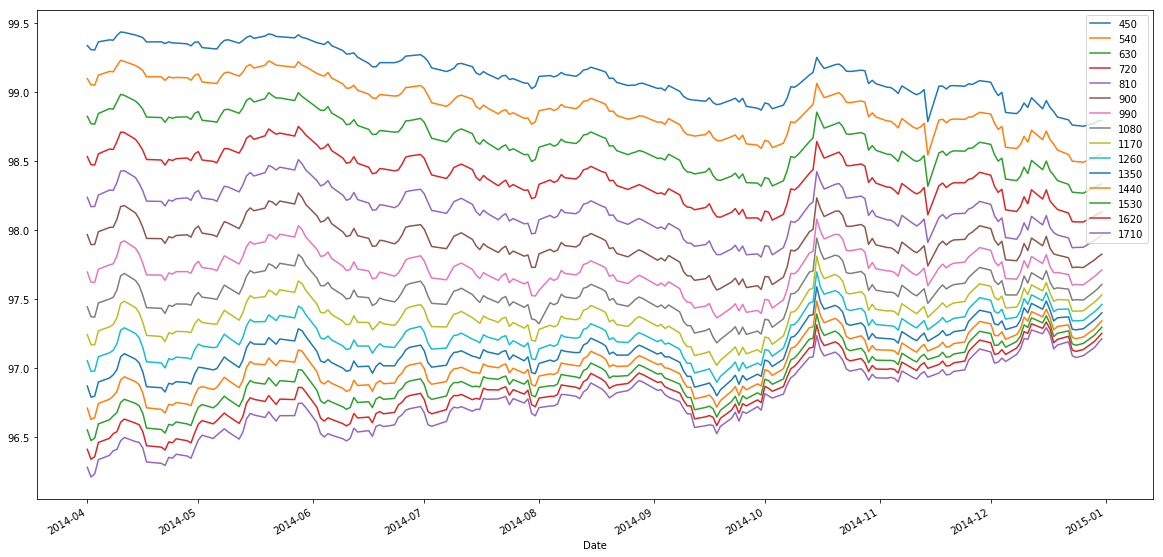

In [7]:
# Convert the rolling data to constant-maturity data
# Set the constant maturiy
constant_maturity = [90*i for i in range(5,20)]
# Get the next maturity date
imm = ql.IMM()

rates_list = []
for index in sample.index:
    today = ql.Date(index.day,index.month,index.year)
    d_current = imm.nextDate(today)
    tau = d_current - today
    taus = [tau]
    for i in range(sample.shape[1]+4-1):
        d_current = imm.nextDate(d_current)
        tau = d_current - today
        taus.append(tau)
    rates = sample.loc[index]

    if (taus[0] == 1) or (taus[0] == 2):
        taus = taus[1:]
        rates = rates[:-1]
    taus = taus[4:]
    rates_inter = np.interp(constant_maturity,taus,rates)
    rates_list.append(rates_inter)
sample_cm = pd.DataFrame(rates_list,index=sample.index,columns=constant_maturity)
sample_cm.plot(figsize=(20,10))
plt.show()

###### Constant Maturity data
As shown above, after converting, there is no periodic jump. I will use constant-maturity data to fit the model in the following

## 2 Model Implementation & Parameter Estimation

### 2.1 1-Factor Vasicek Model Implementation

In [ ]:
class Model:
    def __init__(self,r0,mu,kappa,sigma):
        self.r0 = r0
        self.mu = mu
        self.kappa = kappa
        self.sigma = sigma
    
    # mean of the short-term rate
    def spotrate(self,T0):
        spotrate = np.exp(-self.kappa*T0)*self.r0 + self.mu/self.kappa*(1-np.exp(-self.kappa*T0))
        return spotrate
    
    # variance of the short-term rate
    def spotrate_var(self,T0):
        var = self.sigma**2 / (2 * self.kappa) * (1 -  np.exp(-2*self.kappa * T0))
        return var
    
    # Futures rate
    def futurerate(self,T0,T1,T2,delta=0.25):
        tau1 = T1-T0
        tau2 = T2-T0
        A_diff = self.A(tau1) - self.A(tau2)
        B_diff = self.B(tau1) - self.B(tau2)
        m = self.spotrate(T0)
        v = self.spotrate_var(T0)
        e = np.exp(A_diff - B_diff*m + 0.5 * B_diff**2 * v )
        return (e-1) / delta
    
    # Following are the first-order derivatives on each parameter
    # Used to calculate the Jacobian matrix during optimization
    def f_mu_gradient(self,t0,t1,t2):
        return (self.futurerate(t0,t1,t2) + 1 / (t2 - t1)) * (self.A_mu(t0,t1) - self.A_mu(t0,t1) - self.m_mu(t0) * (self.B(t1-t0)-self.B(t2-t0)))
  
    def f_sigma_gradient(self,t0,t1,t2):
        return (self.futurerate(t0,t1,t2) + 1 / (t2 - t1)) * (self.A_sigma(t0,t1) - self.A_sigma(t0,t2)- 1 / 2 * (self.B(t1-t0) - self.B(t2-t0))**2 * self.v_sigma(t0))
 
    def f_r0_gradient(self,t0,t1,t2):
        return (self.futurerate(t0,t1,t2) + 1 / (t2 - t1)) * (self.B(t1-t0) - self.B(t2-t0)) * self.m_r0(t0)
   
    def f_kappa_gradient(self,t0,t1,t2):
        part1 = self.A_kappa(t0,t1) - self.A_kappa(t0,t2)
        part2 = (self.B_kappa(t0,t1) - self.B_kappa(t0,t2)) * self.spotrate(t0) + (self.B(t1-t0) - self.B(t2-t0)) * self.m_kappa(t0)
        part3 = (self.B(t1-t0) - self.B(t2-t0)) * (self.B_kappa(t0,t1) - self.B_kappa(t0,t2)) * self.spotrate_var(t0) + 1 / 2. * (self.B(t1-t0) - self.B(t2-t0))**2 * self.v_kappa(t0) 
        return (self.futurerate(t0,t1,t2) + 1 / (t2 - t1)) * (part1 - part2 + part3)

    # Get and Update Parameters
    def update_params(self,x):
        self.r0 = x[0]
        self.mu = x[1]
        self.kappa = x[2]
        self.sigma = x[3]
    
    def get_params(self):
        return np.array([self.r0,self.mu,self.kappa,self.sigma])
    
    ###
    # Following are helper function to derive above formula
    ###
    
    # Function A for Ricatti equations
    def A(self,tau):
        A1 = self.mu/self.kappa - self.sigma**2 /(2*self.kappa**2)
        A2 = self.sigma**2 / (4*self.kappa)
        A = A1*(self.B(tau)-tau) - A2*self.B(tau)**2
        return A
    
    # Function B for Ricatti equations
    def B(self,tau):
        B = (1-np.exp(-self.kappa*tau)) / self.kappa
        return B
    
    # Derivatives function
    def A_mu(self,t,T):
        return (self.B(T-t)-T+t) / self.kappa

    def m_mu(self,t0):
        return (1 - np.exp(-self.kappa * t0)) / self.kappa
      
    def A_sigma(self,t,T):
        return 2*self.sigma*(-(self.B(T-t)-T+t) / (2. * self.kappa ** 2) - self.B(T-t) ** 2 / 4./ self.kappa)

    def v_sigma(self,t0):
        return 2*self.sigma*((1 - np.exp(-2 * self.kappa * t0)) / 2. / self.kappa)
  
    def m_r0(self,t0):
        return np.exp(-self.kappa * t0)
  
    def B_kappa(self,t,T):
        return - 1 / self.kappa**2 * (1 - np.exp(-self.kappa * (T - t))) + 1 / self.kappa * (T - t) * np.exp(-self.kappa * (T - t))

    def A_kappa(self,t,T):
        part1 = (-self.mu / self.kappa**2 + self.sigma**2 / self.kappa**3) * (self.B(T-t) - T + t) + (self.mu / self.kappa - self.sigma**2 / 2 / self.kappa**2) * self.B_kappa(t,T)
        part2 = -self.sigma**2 / 4. / self.kappa**2 * self.B(T-t)**2 + self.sigma**2 / 4 / self.kappa * 2 * self.B(T-t) * self.B_kappa(t,T)
        return part1 - part2

    def m_kappa(self,t0):
        return self.r0 * np.exp(-self.kappa * t0) * (-t0) + (-self.mu / self.kappa**2) * (1 - np.exp(-self.kappa * t0)) + self.mu / self.kappa * t0 * np.exp(-self.kappa * t0)

    def v_kappa(self,t0):
        return  -self.sigma**2 / 2 / self.kappa**2 * (1 - np.exp(-2 * self.kappa * t0)) + self.sigma**2 / 2. / self.kappa * 2 * t0 * np.exp(-2 * self.kappa * t0)


### 2.2 Panel Estimation

In [47]:
class Fitter_Inner:
    def __init__(self,model,data,maturities):
        self.model = model
        self.data = np.array(data)
        self.maturities= maturities
    
    def residuals(self,x):
        m = self.model
        m.r0 = x[0]
        rate_dist = [m.futurerate(T1-t_delta1,T1,T1+t_delta2) for T1 in self.maturities]
        price = 100 - 100*np.array(rate_dist)
        return price - self.data
    
    def fit(self,x0):
        # Need to set bound for r0 and vol
        #bound_lower = [0,-np.inf,-np.inf,0]
        #bound_upper = [np.inf,np.inf,np.inf,np.inf]
        #return least_squares(self.residuals,x0,method='trf',bounds=(bound_lower,bound_upper))
        return least_squares(self.residuals,x0,method='lm')


class Fitter_Outer:
    def __init__(self,model,sample_cm,maturities):
        self.model = model
        self.sample_cm = sample_cm
        self.maturities= maturities

    def residuals_outer(self,x):
        m = self.model
        m.mu = x[0]
        m.kappa = x[1]
        print("mu",m.mu)
        print("kappa",m.kappa)
        
        r0_estimate = []
        r0_guess = 0.015
        for i in range(len(self.sample_cm)):
            data = self.sample_cm.iloc[i,:]
            fitter = Fitter_Inner(m,data,cms)
            result = fitter.fit([r0_guess])
            r0_estimate.append(result.x[0])
        r0_estimate = np.array(r0_estimate)
        #print("ro",r0_estimate)
        var_estimated = np.nanvar(np.diff(r0_estimate))
        new_sigma = np.sqrt( 2*m.kappa*var_estimated / (1 - np.exp(-2*m.kappa/252.0)) )
        m.sigma = new_sigma
        print("signma",m.sigma)

        residuals_outer = np.zeros_like(self.sample_cm)
        for i in range(len(self.sample_cm)):
            price = self.sample_cm.iloc[i,:]
            m.r0 = r0_estimate[i]
            futures_hat = np.array([m.futurerate(T1-t_delta1,T1,T1+t_delta2) for T1 in cms])
            price_hat = 100 - 100*futures_hat
            residuals_i = price - price_hat
            residuals_outer[i,:] = residuals_i
        residuals_outer = residuals_outer.flatten()
        return residuals_outer
    
    def fit_outer(self,x0):
        return least_squares(self.residuals_outer,x0,method='lm')
       

In [ ]:
t_delta1 = 2.0 / 365.
t_delta2 = 0.25
# drift parameter
mu = 0.01
kappa = 0.05
# diffusion parameter
sigma = 0.01

r0 = 0

cms = np.array(constant_maturity) / 365.

model = Model(r0,mu,kappa,sigma)

fitter_out = Fitter_Outer(model,sample_cm,cms)
result_fitter = fitter_out.fit_outer([mu,kappa])

In [50]:
model.r0,model.mu,model.kappa,model.sigma
#(-0.004287464807974933, 0.00927863018167423, 0.052735000807760266, 0.008381117343792382)

(-0.004287464807974933,
 0.00927863018167423,
 0.052735000807760266,
 0.008381117343792382)

## 3 Model Testing

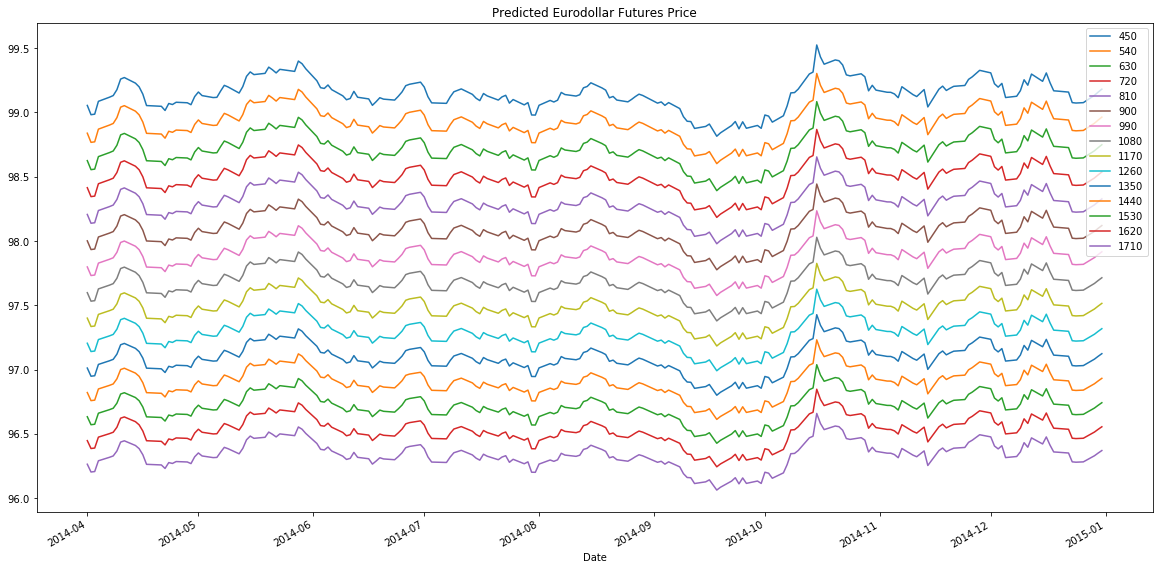

In [58]:
# Calculate the model price
r0_guess = -0.004287464807974933
mu_best = 0.00927863018167423
kappa_best = 0.052735000807760266
sigma_best = 0.008381117343792382

model_best = Model(r0_guess,mu_best,kappa_best,sigma_best)
prices_hat = pd.DataFrame(index=sample_cm.index,columns=sample_cm.columns)
for i in range(len(sample_cm)):
    date = sample_cm.index[i]
    data = sample_cm.iloc[i,:]
    fitter = Fitter_Inner(model_best,data,cms)
    result = fitter.fit([r0_guess])

    future_hat_i = np.array([model_best.futurerate(T1-t_delta1,T1,T1+t_delta2) for T1 in cms])
    prices_hat_i = 100 - 100*future_hat_i
    prices_hat.loc[date] = prices_hat_i
    
prices_hat.plot(figsize=(20,10))  
plt.title('Predicted Eurodollar Futures Price')
plt.show()

### 3.1 In-sample Test

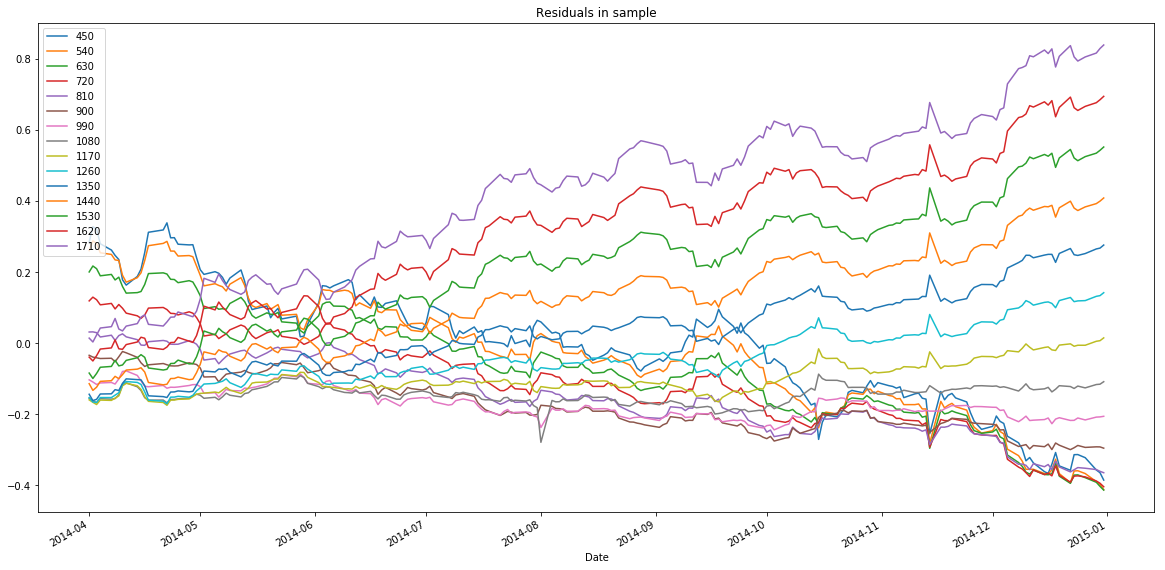

In [64]:
residuals = sample_cm - prices_hat
residuals.plot(figsize=(20,10))
plt.title('Residuals in sample')
plt.show()

In [92]:
def halflife(y):
    y_lag = y.shift(1)
    y_ret = y - y_lag
    y_lag = y_lag[1:]
    y_ret = y_ret[1:]
    y_lag2 = sm.add_constant(y_lag)

    model = sm.OLS(y_ret,y_lag2)
    res = model.fit()

    halflife = round(-np.log(2) / res.params[1],0)
    return halflife


In [ ]:
residuals = residuals.dropna()
for mat in residuals.columns:
    print(' ')
    print ('Costant Maturity: %s days'%mat)
    y = residuals.loc[:,mat]
    y = y.astype(float)
    # Test stationarity
    adf_result = adf(y,autolag="AIC")
    adf_statistic = adf_result[0]
    critical = adf_result[4]['5%'] # Use 99% confidence
    print('The residual is %s stationary'%('' if adf_statistic<critical else 'NOT' ))
    HL = halflife(y)
    print('The half-life is %s'%(round(HL,0)))
    vol = np.std(y)
    print('The volatility is %s'%vol)
    plt.hist(y,25,density=True)
    plt.show()
    
'''
The results are not shown due to limited size of upload files
'''

### 3.2 Out-of-sample Test

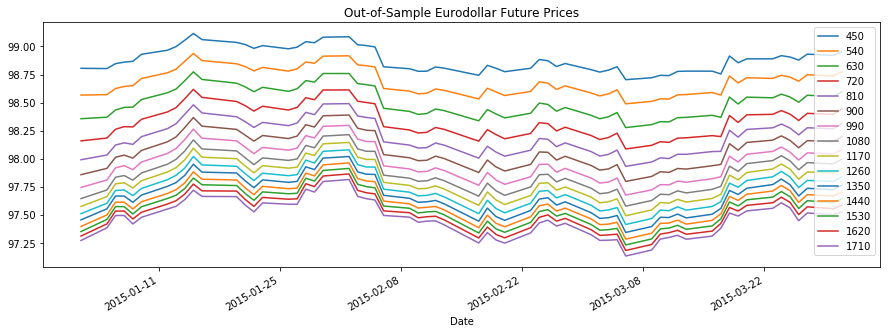

In [102]:
sample_os = df.loc["2015-01-01":"2015-03-31"]

# Convert the rolling data to constant-maturity data

rates_list = []
for index in sample_os.index:
    today = ql.Date(index.day,index.month,index.year)
    d_current = imm.nextDate(today)
    tau = d_current - today
    taus = [tau]
    for i in range(sample_os.shape[1]+4-1):
        d_current = imm.nextDate(d_current)
        tau = d_current - today
        taus.append(tau)
    rates = sample_os.loc[index]

    if (taus[0] == 1) or (taus[0] == 2):
        taus = taus[1:]
        rates = rates[:-1]
    taus = taus[4:]
    rates_inter = np.interp(constant_maturity,taus,rates)
    rates_list.append(rates_inter)
sample_cm_os = pd.DataFrame(rates_list,index=sample_os.index,columns=constant_maturity)
sample_cm_os.plot(figsize=(15,5))
plt.title('Out-of-Sample Eurodollar Future Prices')
plt.show()

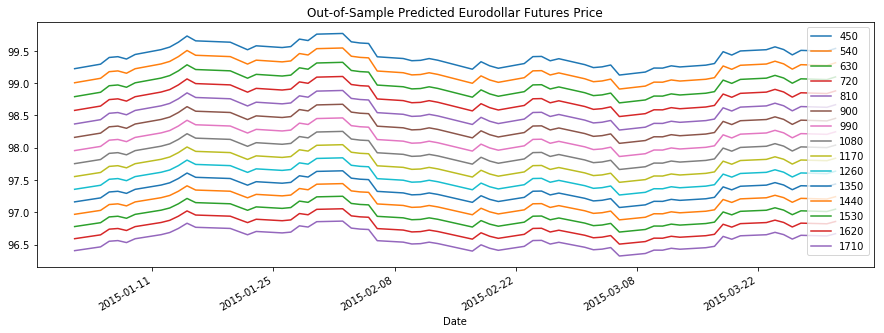

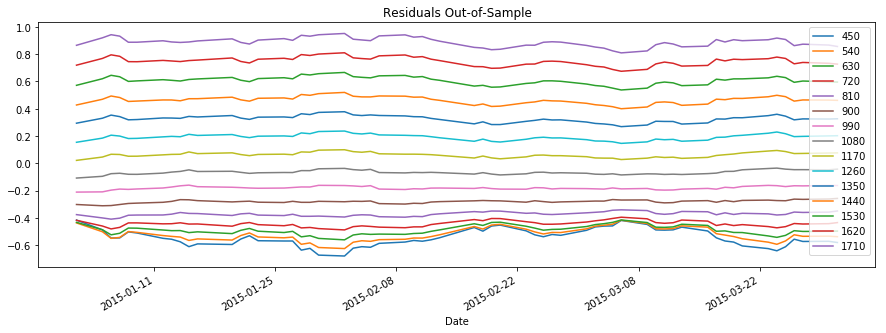

In [106]:
r0_guess = -0.004287464807974933
mu_best = 0.00927863018167423
kappa_best = 0.052735000807760266
sigma_best = 0.008381117343792382

model_best = Model(r0_guess,mu_best,kappa_best,sigma_best)
prices_hat_os = pd.DataFrame(index=sample_cm_os.index,columns=sample_cm_os.columns)
for i in range(len(sample_cm_os)):
    date = sample_cm_os.index[i]
    data = sample_cm_os.iloc[i,:]
    fitter = Fitter_Inner(model_best,data,cms)
    result = fitter.fit([r0_guess])

    future_hat_i = np.array([model_best.futurerate(T1-t_delta1,T1,T1+t_delta2) for T1 in cms])
    prices_hat_i = 100 - 100*future_hat_i
    prices_hat_os.loc[date] = prices_hat_i
    
prices_hat_os.plot(figsize=(15,5))  
plt.title('Out-of-Sample Predicted Eurodollar Futures Price')
plt.show()
residuals_os = sample_cm_os - prices_hat_os
residuals_os.plot(figsize=(15,5))
plt.title('Residuals Out-of-Sample')
plt.show()

In [ ]:
for mat in residuals_os.columns:
    print(' ')
    print ('Costant Maturity: %s days'%mat)
    y = residuals_os.loc[:,mat]
    y = y.astype(float)
    # Test stationarity
    adf_result = adf(y,autolag="AIC")
    adf_statistic = adf_result[0]
    critical = adf_result[4]['5%'] # Use 99% confidence
    print('The residual is %s stationary'%('' if adf_statistic<critical else 'NOT' ))
    HL = halflife(y)
    print('The half-life is %s'%(round(HL,0)))
    vol = np.std(y)
    print('The volatility is %s'%vol)
    plt.hist(y,25,density=True)
    plt.show()
'''
The results are not shown due to limited size of upload files
'''

### Conclusion
Although the model price follow similar trend as the actual price, its result is not precise enough. However, the above sample already shows examples about how to build a model and estimate its parameter. In the future, we could implement 2-F Vasicek or other models with the same framework and procedures. With more factors consideres, the results will be more precise.

## 4 Prediction & Parameter Sensitivity
Calculate probability of negative short rates at 10 yrs

In [131]:
T0 = 10
mean_r = model_best.spotrate(T0)
std_r = np.sqrt(model_best.spotrate_var(T0))
probability = norm.cdf(-mean_r / std_r)
probability

0.0006135755679112897

In [136]:
# Test sensitivity of this result to various parameters
r0 = model_best.r0
mu_best = 0.00927863018167423
kappa_best = 0.052735000807760266
sigma_best = 0.008381117343792382

# Test mu 
mu_up = mu_best * 1.01  # 1 percent change
mu_down = mu_best * 0.99
model_up = Model(r0,mu_up,kappa_best,sigma_best)
model_down = Model(r0,mu_down,kappa_best,sigma_best)
pro_up =  norm.cdf(-model_up.spotrate(T0) /np.sqrt( model_up.spotrate_var(T0)))
pro_down =  norm.cdf(-model_down.spotrate(T0) / np.sqrt(model_down.spotrate_var(T0)))
sensitivity_mu = (pro_up - pro_down) / (0.01*2)
print('For every 1 percent change of mu, the probability of negative yield at 10 yr will change %.2f percent'%(100*sensitivity_mu))

# Test kappa
kappa_up = kappa_best * 1.01  # 1 percent change
kappa_down = kappa_best * 0.99
model_up = Model(r0,mu_best,kappa_up,sigma_best)
model_down = Model(r0,mu_best,kappa_down,sigma_best)
pro_up =  norm.cdf(-model_up.spotrate(T0) /np.sqrt( model_up.spotrate_var(T0)))
pro_down =  norm.cdf(-model_down.spotrate(T0) / np.sqrt(model_down.spotrate_var(T0)))
sensitivity_mu = (pro_up - pro_down) / (0.01*2)
print('For every 1 percent change of kappa, the probability of negative yield at 10 yr will change %.2f percent'%(100*sensitivity_mu))

# Test sigma
sigma_up = sigma_best * 1.01  # 1 percent change
sigma_down = sigma_best * 0.99
model_up = Model(r0,mu_best,kappa_best,sigma_up)
model_down = Model(r0,mu_best,kappa_best,sigma_down)
pro_up =  norm.cdf(-model_up.spotrate(T0) /np.sqrt(model_up.spotrate_var(T0)))
pro_down =  norm.cdf(-model_down.spotrate(T0) / np.sqrt(model_down.spotrate_var(T0)))
sensitivity_mu = (pro_up - pro_down) / (0.01*2)
print('For every 1 percent change of kappa, the probability of negative yield at 10 yr will change %.2f percent'%(100*sensitivity_mu))

For every 1 percent change of mu, the probability of negative yield at 10 yr will change -0.74 percent
For every 1 percent change of kappa, the probability of negative yield at 10 yr will change 0.00 percent
For every 1 percent change of kappa, the probability of negative yield at 10 yr will change 0.69 percent
